<a href="https://colab.research.google.com/github/mmaryam2020/COVID-19-Question-Answering-System/blob/main/COVID_19_Question_Answering_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install pyLDAvis==3.2.2
!pip install langdetect

In [ ]:
# Basics

import string
import random
import logging
import datetime
from tqdm import tqdm
from pathlib import Path
from copy import deepcopy
from unicodedata import normalize


# NLP
import nltk
import spacy
from langdetect import detect
from gensim.utils import deaccent
from nltk.corpus import stopwords
from gensim.models import CoherenceModel, TfidfModel
from gensim.models import LdaModel, LdaMulticore
from gensim.models.phrases import Phrases, Phraser
from gensim.corpora import Dictionary
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
#from pyjarowinkler import distance

# Graphs
import networkx as nx

# Data Science
#import umap
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Visuals
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import pyLDAvis
from pyLDAvis import gensim
from wordcloud import WordCloud, STOPWORDS

%matplotlib inline

import functools
from IPython.core.display import display, HTML
from nltk import PorterStemmer
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Introduction

We implemented a model in this project that will be generalizable to new questions, and it won't be limited to specific keys. So we use the modern machine learning models called Question Answering models that integrated transformers. 

As the Covid article dataset is too large, our purpose was to build a model that can almost answer most of the questions related to Covid among these versatile articles.

We use this considerable dataset as a context to fine-tune language models and extract our favorable answers from them. 
After reviewing cuttin-edge methods in the field, we decided that the Roberta-Squad model and Biober-model, which are both Bert-Basd models, can be a desirable solution to our problem. 

.




### Mount Goodle Drive and Give Metadata Path


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Data Exploration

In this part, we first cleand the dataset

In [ ]:
df=pd.read_csv('metadata.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497906 entries, 0 to 497905
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   cord_uid          497906 non-null  object 
 1   sha               172105 non-null  object 
 2   source_x          497906 non-null  object 
 3   title             497674 non-null  object 
 4   doi               281753 non-null  object 
 5   pmcid             182522 non-null  object 
 6   pubmed_id         241936 non-null  object 
 7   license           497906 non-null  object 
 8   abstract          363064 non-null  object 
 9   publish_time      497687 non-null  object 
 10  authors           484020 non-null  object 
 11  journal           464755 non-null  object 
 12  mag_id            0 non-null       float64
 13  who_covidence_id  197568 non-null  object 
 14  arxiv_id          6687 non-null    object 
 15  pdf_json_files    172105 non-null  object 
 16  pmc_json_files    13

In [ ]:
df=df[['cord_uid' , 'title' , 'doi' , 'abstract' , 'publish_time' , 'authors' , 'journal' , 'url' ]]

In [ ]:
#drop nulls
#As data is too large we will drop all null columns
df = df.dropna()


In [ ]:
df.head()

,cord_uid,title,doi,abstract,publish_time,authors,journal,url
0,ug7v899j,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...
1,02tnwd4m,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...
2,ejv2xln0,Surfactant protein-D and pulmonary host defense,10.1186/rr19,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...
3,2b73a28n,Role of endothelin-1 in lung disease,10.1186/rr44,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...
4,9785vg6d,Gene expression in epithelial cells in respons...,10.1186/rr61,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...


In [ ]:
#clean dataset and drop duplicates
df=df.drop_duplicates(subset=['cord_uid'])
df["abstract"] = df["abstract"].str.lower()
df ['title'] = df ['title'].str.lower()
df = df.drop_duplicates (subset=[ 'title'])
df = df.drop_duplicates  (subset = ['abstract'])

In [ ]:
df.shape

(198290, 8)

extracts all the abstracts that contain the keywords covid, -cov-2, -cov2, and .... that are sysnonyms for COVID

In [ ]:
#keep articles related to Covid
covid_words=['coronavirus','Covid-19','Corona virus','COVID 19','covid-19', 'Coronavirus', 'cov-2',  'hcov', '2019-ncov' , 'sarscov','sarscov2', 'ncov']
df = df[df['abstract'].str.contains('|'.join(covid_words))]


In [ ]:
#keep only papers of 2020 and 2021
df['publish_time'] = df['publish_time'].astype('datetime64')
df = df [df['publish_time'].dt.year>=2020]

In [ ]:
df.shape

(80250, 8)

## Seperating English Articles

In [ ]:
#detect language of Articles
!pip install langdetect
from tqdm import tqdm
from langdetect import detect
from langdetect import DetectorFactory

# set seed
DetectorFactory.seed = 0

# hold label - language
languages = []

# go through each text
for i in tqdm(range(0,len(df))):
    # split by space into list, take the first x intex, join with space
    text = df.iloc[i]['abstract'].split(" ")
    
    lang = 'en'           
    try:
        # let's try to label it through the abstract then
        lang = detect(df.iloc[i]['abstract'])
    except Exception as e:
        lang = "unknown"
        pass
    
    # get the language    
    languages.append(lang)

100%|██████████| 80250/80250 [12:13<00:00, 109.38it/s]


In [ ]:
from pprint import pprint
languages_dict = {}
for lang in set(languages):
    languages_dict[lang] = languages.count(lang)
    
print("Total: {}\n".format(len(languages)))
pprint(languages_dict)

Total: 80250

{'de': 69,
 'en': 79541,
 'es': 237,
 'fr': 294,
 'hu': 12,
 'it': 7,
 'ko': 2,
 'nl': 41,
 'pt': 7,
 'zh-cn': 40}


In [ ]:
#seperate_English_article
df['language'] = languages
df = df[df['language'] == 'en']

In [ ]:
df.shape

(79541, 9)

## Save clean dataset in the drive

In [ ]:
#save cleand dataset to drive

df.to_csv('metadata_cleaned.csv' , index=False)

In [ ]:
#read clean dataset
df=pd.read_csv('metadata_cleaned.csv')

In [ ]:
df.head()

,cord_uid,title,doi,abstract,publish_time,authors,journal,url,language
0,n5kliexp,cocaine and amphetamine-regulated transcript p...,10.1186/s12967-020-02208-z,background: epidemiologic studies show that co...,2020-01-09,"Mahmoudi-Nezhad, Mahsa; Farhangi, Mahdieh Abba...",J Transl Med,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,en
1,2jq626ye,therapeutic strategies in an outbreak scenario...,10.12688/f1000research.22211.2,a novel coronavirus (2019-ncov) originating in...,2020-02-07,"Kruse, Robert L.",F1000Res,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,en
2,rqlnve7r,single-virus tracking: from imaging methodolog...,10.1021/acs.chemrev.9b00692,[image: see text] uncovering the mechanisms of...,2020-01-17,"Liu, Shu-Lin; Wang, Zhi-Gang; Xie, Hai-Yan; Li...",Chem Rev,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,en
3,uq7bpmbi,epidemics with mutating infectivity on small-w...,10.1038/s41598-020-62597-5,epidemics and evolution of many pathogens occu...,2020-04-03,"Rüdiger, Sten; Plietzsch, Anton; Sagués, Franc...",Sci Rep,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,en
4,zhw8vh3e,artificial intelligence (ai) applications for ...,10.1016/j.dsx.2020.04.012,background and aims: healthcare delivery requi...,2020-04-14,"Vaishya, Raju; Javaid, Mohd; Khan, Ibrahim Hal...",Diabetes Metab Syndr,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,en


In [ ]:
#sample articles as their numbers for language models is still  large and my computation resource is limited
df = df.sample(n=50000, random_state=42)

# Data Visualization and Exploratory Data Analysis 

For data exploration, we used topic modeling to gain insight about data and the most important topics covered in this huge dataset. As we will implement an advanced NLP Question-Answering model, this analysis can help us ask better questions or find out if the answer is relevant to our question according to dominant articles.

LDA is an unsupervised machine-learning model that takes documents as input and gives topics as output. Here are some pros of using LDA.

* Unsupervised: no need of labelling data
* Fast: pretty fast to execute if well parametrized
* Easy to implement



## Cleaning Text
First we define a preprocessor to process raw text befor passing it to the model. In this preprocessin we did these steps with the help of spacy package.
Delete special characters
Tokenize
Lemmatize
Delete stopwords
Delete numbers tokens, tokens of url, emails, etc.
Filter  short tokens
Deaccent 


In [ ]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nlp = spacy.load("en_core_web_sm")

lemmatizer = WordNetLemmatizer()
stop_list_nltk = list(set(stopwords.words('english')))
stop_list_spacy = list(spacy.lang.en.stop_words.STOP_WORDS)
stop_list_custom=[
        'positives', 'true', 'false', 'tp', 'fp' 'cc_nc', 'q_q', 'r', 'b', 'p', 'q', 'h', 'cc', 'doi', 'medrxiv', 'fig', 'org', 'tb'
         ]   
stop_list_all = stop_list_nltk+stop_list_spacy+stop_list_custom

def preprocess(text):
        """
        Main function to preprocess the text
        """
        min_token_len=1
        # Delete some punctuation before preprocessing BUT not all of it because some can be involved in n-grams (e.g. "-")
        text=re.sub(r'[!"#$%&\'()*+,./:;<=>?@\[\\\]^_`{|}~]',r' ',text) 
        doc = nlp(text)
        tokens = [
              token.lemma_ for token in doc if
              token.lemma_ != '-PRON-'
              and not token.is_punct
              and not token.is_digit
              and not token.like_num
              and not token.like_url
              and not token.like_email
              and len(token.lemma_) >= min_token_len and len(token.text) >= min_token_len
              and token.lemma_.lower() not in stop_list_all and token.text.lower() not in stop_list_all
          ]
        
        # Recreation of the text
        text = " ".join(tokens)

        # Remove accents
        text = deaccent(text)
    
        # Remove double spaces
        text=re.sub(r'\s+',r' ',text)
        
        # Set as lowercase
        text = text.lower().strip()


        return text

In [ ]:
 #Test Preprocessing Function
 x= preprocess(df['abstract'][0])
 print(x)

background epidemiologic study cocaine- amphetamine regulate transcript prepropeptide cartpt gene polymorphism modifie diet obesity relationship interaction cartpt gene polymorphism diet quality index investigate current study aim evaluate interaction major dietary index include diet quality index international dqi healthy eat index hei cartpt gene rs2239670 variant apparently healthy obese iranians method cross sectional study carry employ apparently healthy obese adult age 20–50 year bmi 30–40 kg diet quality evaluate diet quality index international dqi healthy eat index-2015 hei-2015 132-items semi quantitative validated food frequency questionnaire cartpt gene rs2239670 polymorphism genotype polymerase chain reaction restriction fragment length polymorphism pcr rflp technique blood concentration glycemic marker lipid profile α melanocyte stimulate hormone msh agouti relate peptide agrp measure ancova multivariate interaction model analyze gene diet interaction result significant i

In [ ]:
#Merging Title and Abstract for Topic Modeling
df_merged = pd.DataFrame([])
df_merged ['title_abstract'] = df ['title'].astype(str) +'\n'+ df ['abstract'].astype(str)

In [ ]:
df_merged["title_abstract_preprocessed"] = df_merged.apply(
        lambda x: preprocess(x["title_abstract"]), axis=1
    )

In [ ]:
# Split to tokens
docs_tokens = [doc.split() for doc in list(df_merged.title_abstract_preprocessed)]

In [ ]:
# Infer bigram model
bigram_mod = Phraser(Phrases(docs_tokens, min_count=10, threshold=10))

In [ ]:
# Get bigrams
docs_bigram_tokens = [bigram_mod[doc] for doc in docs_tokens]

In [ ]:
# Create Dictionary
id2word = Dictionary(docs_bigram_tokens)
id2word.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [ ]:
# Term Document Frequency
bow_corpus = [id2word.doc2bow(doc) for doc in docs_bigram_tokens]

In [ ]:
# TF-IDF Document Frequency
tfidf = TfidfModel(bow_corpus)
tfidf_corpus = tfidf[bow_corpus]


In [ ]:
#Train multiple LDA models in an indicated range of number of topics  
def find_num_topics(dictionary, corpus, docs, end, start=2, step=2):
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, end, step)):
        model = LdaModel(
            corpus=corpus,
            num_topics=num_topics,
            id2word=id2word,
            update_every=1,
            eval_every = 100,
            random_state=100,
            chunksize=2000,
            passes=4,
            iterations=100,
            per_word_topics=True,
        )

        model_list.append(model)
        coherencemodel = CoherenceModel(
            model=model, texts=docs, dictionary=dictionary, coherence="c_v"
        )
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
#Generate a visulization of LDA topics
def visualize_topics(lda_model, corpus, id2word):
    pyLDAvis.enable_notebook()
    
    return pyLDAvis.gensim.prepare(lda_model, corpus, id2word)


In [ ]:
#Print topics made of keywords found in LDA model
def print_topics(lda_model):
   
    columns_name = []
    pd_dict = {}

    num_topic = lda_model.num_topics
    for i in range(num_topic):
        columns_name.append(((f"Topic_{i+1}", "Word")))
        words, weight = zip(*lda_model.show_topic(i))
        pd_dict[f"topic{i+1}"] = list(words)

    df = pd.DataFrame(pd_dict)

    return df

We use two variants of LDA, LDA TF_IDF and LDA BOW. Then we genrate multiple LDA models with different number of topics as a main hyper-parameter to find the best model according the  highest coherence score and perplexity score.

In [ ]:
start_topic, end_topic, step = 10, 18, 2

# Train LDA models with TF-IDF corpus
model_list, coherence_values = find_num_topics(
    dictionary=id2word,
    corpus=tfidf_corpus,
    docs=docs_bigram_tokens, 
    start=start_topic, 
    end=end_topic,
    step=step
    )

100%|██████████| 4/4 [11:01<00:00, 165.46s/it]


In [ ]:
tfidf_lda_model = model_list[1]

In [ ]:
# Compute Perplexity
print('Perplexity: ', tfidf_lda_model.log_perplexity(bow_corpus))

Perplexity:  -8.072321396639873


In [ ]:
print_topics(tfidf_lda_model)

,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10,topic11,topic12
0,sars_cov-2,copd,model,ms,patient,ibd,medical_student,msc,meta_analysis,learning,anxiety,health
1,cell,brain,detection,palliative_care,severe,pe,pa,air_quality,hcq,teacher,mental_health,care
2,protein,mirna,assay,multiple_sclerosis,sars_cov-2,myocarditis,wastewater,ifn,systematic_review,dentist,stress,impact
3,virus,mouse,predict,migrant,case,mis_c,air_pollution,furin,aki,epilepsy,hcw,outbreak
4,drug,endothelial_cell,sample,cvd,infection,hr_ci,sport,labor,recipient,curriculum,psychological,country
5,vaccine,college_student,prediction,pedv,mortality,app,medical_education,mesenchymal_stem,transplant,faculty,participant,patient
6,human,ace2_tmprss2,main_protease,veteran,disease,multisystem_inflammatory,cxr,stem_cell,breast_cancer,saudi_arabia,fear,risk
7,ace2,expression_ace2,performance,portugal,pneumonia,acei_arb,pd,nanoparticle,kidney_transplant,competency,anxiety_depression,case
8,viral,neurological_symptom,dataset,ad,day,coagulopathy,hf,hip_fracture,transplantation,nursing_student,score,lockdown
9,target,olfactory_dysfunction,2019-ncov,protective_behavior,group,hamster,medical_school,nps,sexual,teach,caregiver,service


In [ ]:
tfidf_lda_model.save('tfidf_lda_model')

## Visualiztion of Most commonly used words in topics with pyLDAVis
pyLDAVis is the most commonly used and a nice way to visualise the information contained in a topic model

In [ ]:
from pyLDAvis import gensim

In [ ]:
visualize_topics(tfidf_lda_model, tfidf_corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11     0.308584 -0.029471       1        1  35.329078
4      0.295797  0.012033       2        1  21.498618
0      0.252042 -0.114899       3        1  11.618876
2      0.062004  0.046254       4        1   6.992598
10     0.007264  0.319589       5        1   5.794217
6     -0.137331  0.096599       6        1   2.983995
5     -0.139457 -0.093286       7        1   2.950286
8     -0.130072 -0.068843       8        1   2.839273
9     -0.139495  0.053423       9        1   2.756664
1     -0.118631 -0.076669      10        1   2.458559
7     -0.133007 -0.090794      11        1   2.446031
3     -0.127698 -0.053937      12        1   2.331804, topic_info=                        Term         Freq  ...  logprob  loglift
130                  patient  1126.000000  ...  30.0000  30.0000
74                sars_cov-2   927.000000  ...  29.0000  29.0000
207                    model   397.000000  ...  28.0000  28.0000
1175           mental_health   281.000000  ...  27.0000  27.0000
723                     cell   337.000000  ...  26.0000  26.0000
...                      ...          ...  ...      ...      ...
5495                   probe    21.480402  ...  -5.8708   3.5126
4354       article_summarize    17.513393  ...  -6.0750   3.5521
11193  hypercoagulable_state    17.720222  ...  -6.0633   3.5153
2590         thromboembolism    18.392674  ...  -6.0260   3.3784
4451                  native    17.677669  ...  -6.0657   3.2473

[691 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
2297       1  0.490374    2019-ncov
2297       4  0.499131    2019-ncov
2826       4  0.964267           ab
248        2  0.979836  abnormality
12631      6  0.941492     abortion
...      ...       ...          ...
4714       8  0.055284        x_ray
8200      11  0.973663     zip_code
1654       4  0.860102     zoonotic
1654       5  0.050594     zoonotic
1654       6  0.050594     zoonotic

[1230 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 5, 1, 3, 11, 7, 6, 9, 10, 2, 8, 4])

In [ ]:
p_tfidf = visualize_topics(tfidf_lda_model, tfidf_corpus, id2word)
pyLDAvis.save_html(p_tfidf, 'tfidf_lda.html')

### To show inside Jupyte, I took a screenshot from interactive plot in colab 
### pyLDAvis TF_IDF model

<div>
<img src="https://drive.google.com/uc?export=view&id=1PQUcxWKk807OfGH3cVnbJdTOVR7ery1h" width="1000"/>
</div>


In [ ]:
start_topic, end_topic, step = 10, 18, 2

# Train LDA bow models
model_list, coherence_values = find_num_topics(
    dictionary=id2word,
    corpus=bow_corpus,
    docs=docs_bigram_tokens, 
    start=start_topic, 
    end=end_topic,
    step=step
    )

100%|██████████| 4/4 [10:57<00:00, 164.36s/it]


In [ ]:
bow_lda_model = model_list[1]

In [ ]:
# Compute Perplexity
print('Perplexity: ', bow_lda_model.log_perplexity(bow_corpus))

Perplexity:  -9.849121143666771


In [ ]:
print_topics(bow_lda_model)

,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10,topic11,topic12
0,during,patient,were,case,sars-cov-2,research,infection,treatment,patient,patient,during,study
1,were,care,patient,it,virus,health,disease,vaccine,p_0,case,wa,data
2,wa,during,wa,are,by,their,are,drug,were,wa,period,were
3,study,are,1,country,we,by,sars-cov-2,or,wa,treatment,by,we
4,survey,management,2,we,infection,an,it,study,severe,pneumonia,were,risk
5,mental_health,risk,3,outbreak,human,from,covid‐19,trial,or,infection,number,result
6,among,an,5,epidemic,from,we,severe,use,group,symptom,from,from
7,participant,service,0,from,are,student,respiratory_syndrome,efficacy,mortality,clinical,at,death
8,their,hospital,4,spread,viral,education,patient,therapy,0,diagnosis,change,wa
9,result,need,6,model,cell,using,have,clinical_trial,outcome,an,reduction,or


In [ ]:
bow_lda_model.save('bow_lda_model')

In [ ]:
visualize_topics(bow_lda_model, bow_corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.178928  0.158907       1        1  15.659614
3      0.019911 -0.204216       2        1  12.294452
10    -0.163204 -0.073529       3        1  11.335911
11     0.169211  0.098455       4        1  11.258820
1     -0.006697 -0.012839       5        1  10.145739
0     -0.134505 -0.085050       6        1   6.881096
4     -0.158253  0.110553       7        1   6.648210
9     -0.033801  0.181726       8        1   5.905387
5      0.030309 -0.227044       9        1   5.856506
6      0.253450  0.103463      10        1   4.962405
8      0.066725 -0.050060      11        1   4.618238
2      0.135782 -0.000367      12        1   4.433624, topic_info=           Term           Freq          Total Category  logprob  loglift
130     patient  100242.000000  100242.000000  Default  30.0000  30.0000
74   sars_cov-2   52798.000000   52798.000000  Default  29.0000  29.0000
493   treatment   18121.000000   18121.000000  Default  28.0000  28.0000
8          case   28039.000000   28039.000000  Default  27.0000  27.0000
48    infection   36445.000000   36445.000000  Default  26.0000  26.0000
..          ...            ...            ...      ...      ...      ...
72       report    1278.004417   20303.301243  Topic12  -5.1860   0.3505
162  conclusion    1193.342313   15962.022541  Topic12  -5.2545   0.5225
358        find    1030.486993    9306.589571  Topic12  -5.4013   0.9153
717    activity     941.691866    5427.725639  Topic12  -5.4914   1.3644
231    research     985.049046    8109.760792  Topic12  -5.4464   1.0078

[956 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
9905     12  0.994342    3clpro
608       1  0.039099  academic
608       2  0.174644  academic
608       3  0.054739  academic
608       6  0.006082  academic
...     ...       ...       ...
498       7  0.015104      year
498       8  0.009402      year
498       9  0.055331      year
498      11  0.031596      year
498      12  0.003082      year

[3019 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 4, 11, 12, 2, 1, 5, 10, 6, 7, 9, 3])

In [ ]:
p_bow = visualize_topics(bow_lda_model, bow_corpus, id2word)
pyLDAvis.save_html(p_bow, 'bow_lda.html')

### To show inside Jupyte, I took a screenshot from interactive plo in colab 
### pyLDAvis BOW model

<div>
<img src="https://drive.google.com/uc?export=view&id=1e7JMba9nut4mETd2nzIW5COaaWhKswKD" width="1000"/>
</div>



## Discussion

The results gained from LDA modeling is so interesting. According to the table of top words of each topic and pyLDAvis visualization, we can figure out important keywords discussed in each topic. For instance, according to the TF-IDF table, topic 3 is relevant to analytical and datascience papers that intend to analyze Covid issues based on available data, or topic 1 is probably related to developed drug and vaccines to combat Covid.

Based on the table, the TF_IDF has shown better results and more insightful keywords in comparison to BOW.

## Word Cloud
Though you’ve already seen what are the topic keywords in each topic, a word cloud with the size of the words proportional to the weight can give us a quick insight about data

In [ ]:
# read the mask image from bottle
from PIL import Image
covid_mask = np.array(Image.open("/content/cloud.png"))

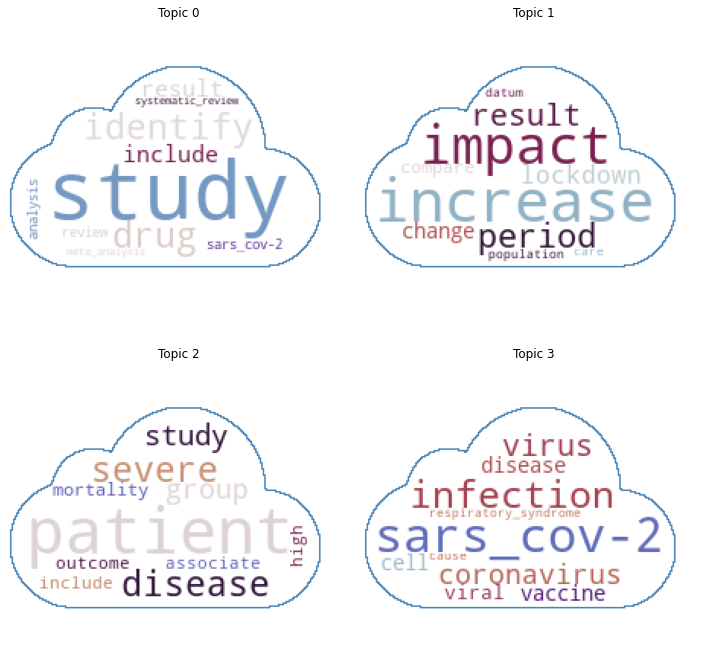

In [ ]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors


cloud = WordCloud(stopwords=stop_list_all,
                  background_color='white',
                  width=1800,
                  height=2500,
                  max_words=25,
                  colormap='twilight',
                  mask = covid_mask,
                  collocations=True,
                  contour_width=1,
                  contour_color='steelblue'
                 )

topics = bow_lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=12))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.savefig('Topics Word Clouds.png')
plt.show()


## Word Counts of Topic Keywords
 
When it comes to the keywords in the topics, the importance (weights) of the keywords matters. Also, how frequently the words have appeared in the documents can give valuable insight to us. 
So we plot the word counts and the weights of each keyword in the same chart. Words that occur in multiple topics and the ones with relative frequencies higher than the weight are often less important. 




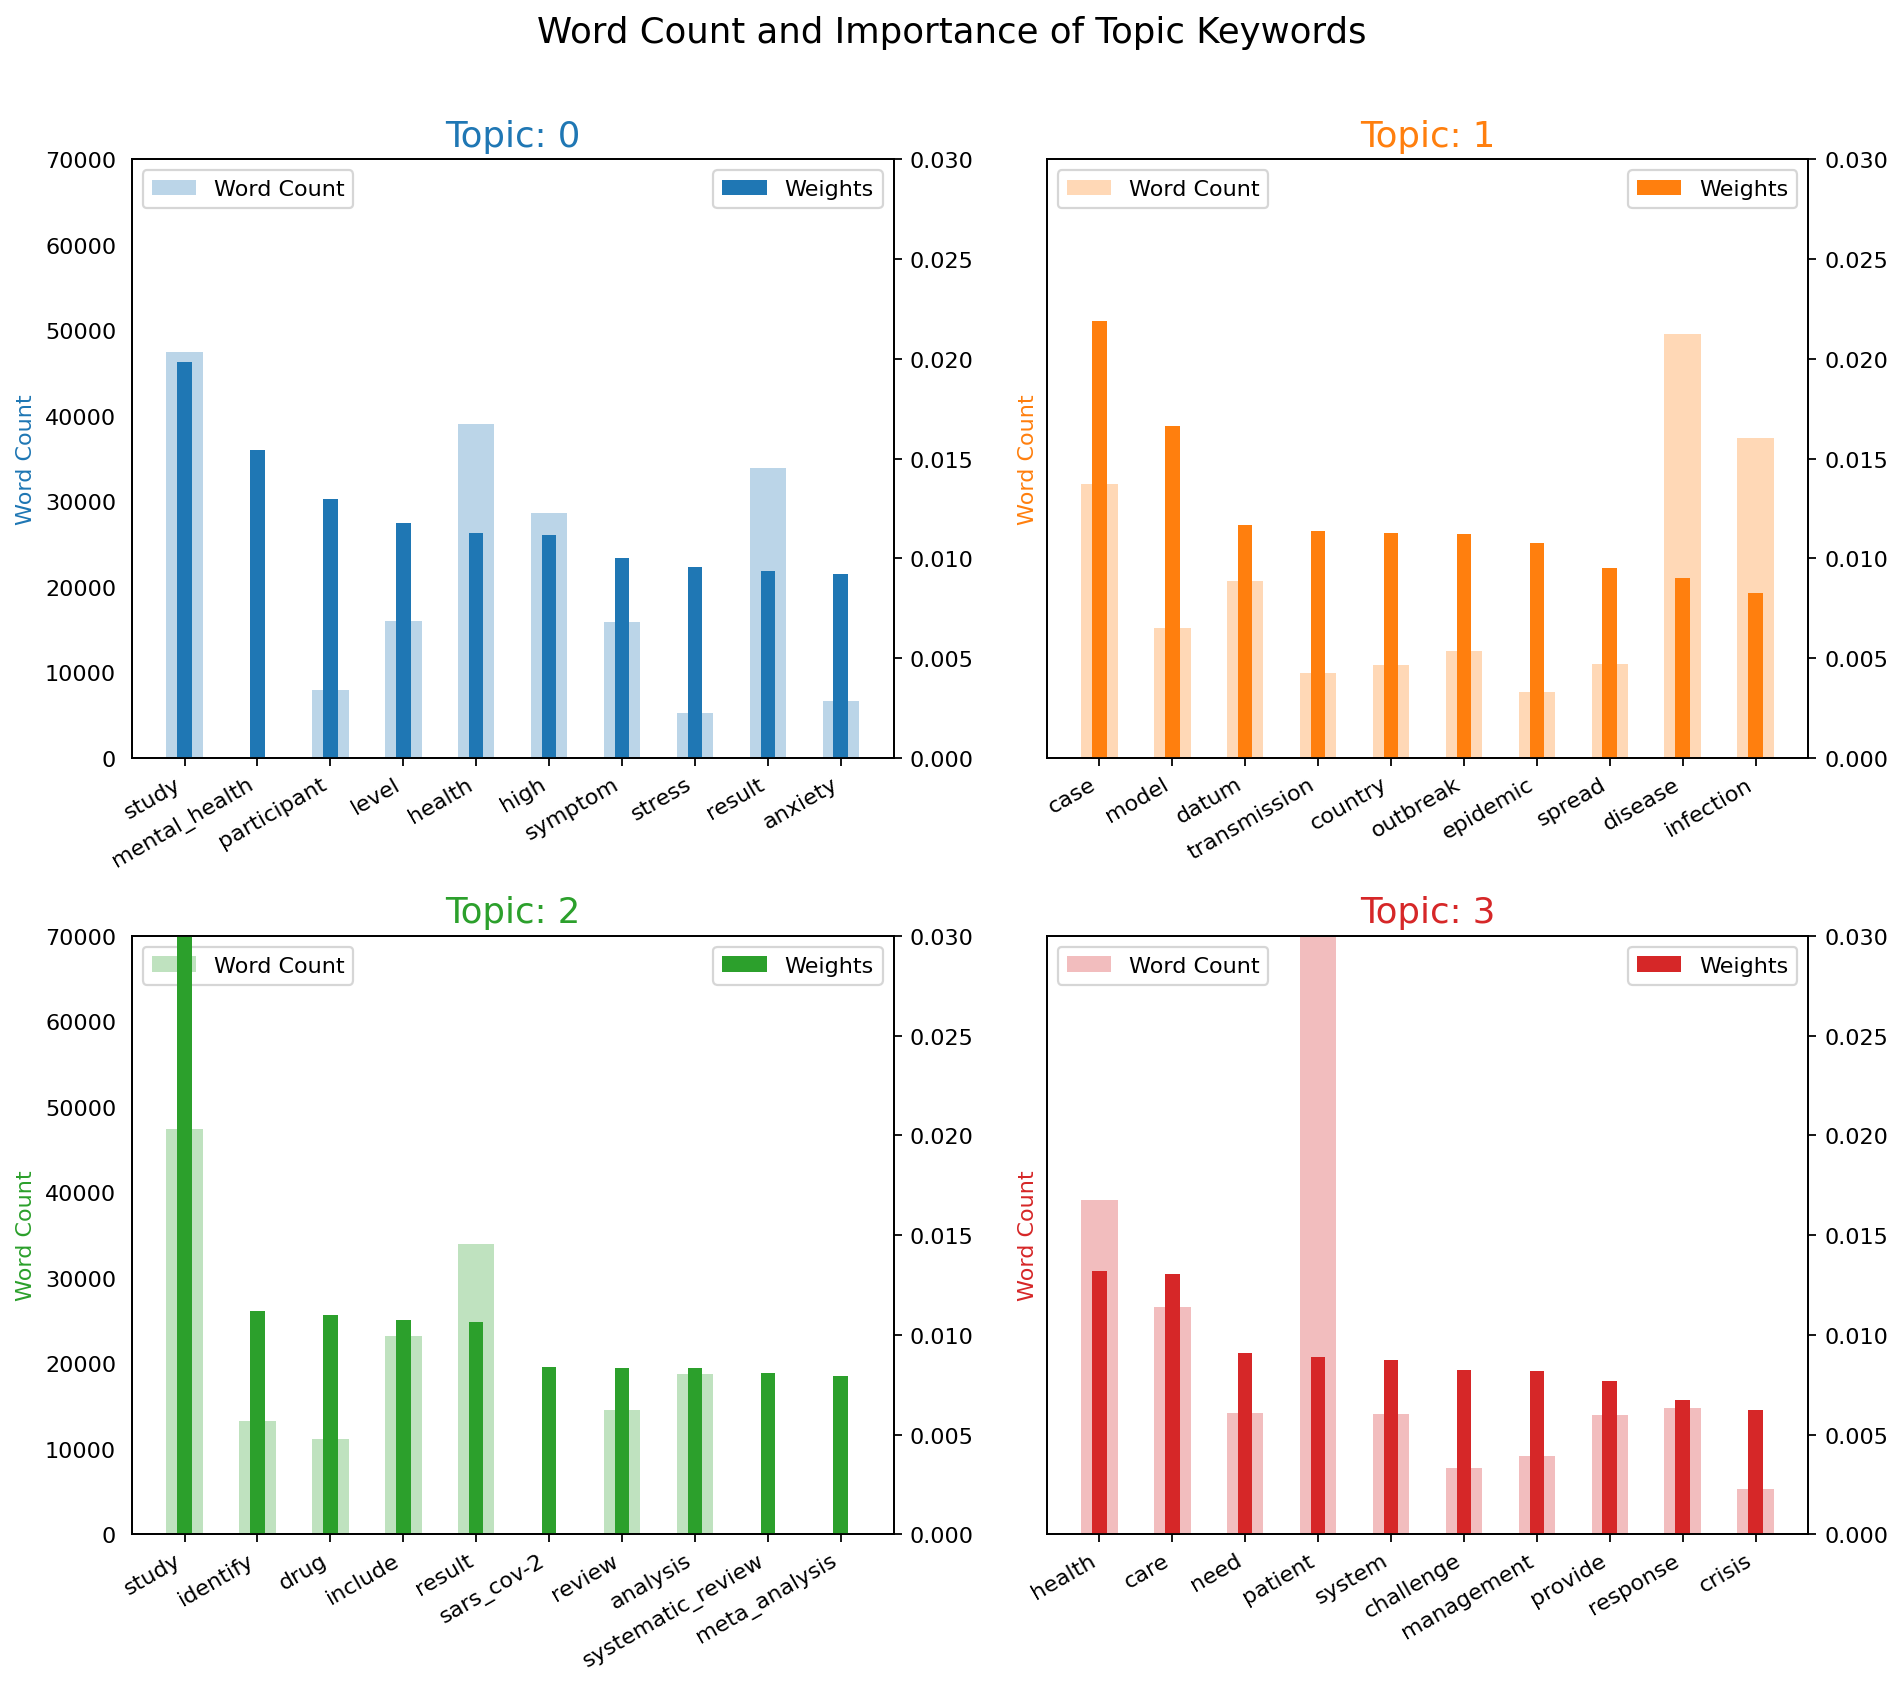

In [ ]:
from collections import Counter
topics = bow_lda_model.show_topics(formatted=False)
data_flat = [w for w_list in docs_tokens for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(12,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 70000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=16, y=1.05)   
plt.savefig('Word Count and Importance of Topic Keywords.png')
plt.show()

# Model selection
Question Answering models help us to find information more efficiently especially in problems that we have a large dataset and we like to gain insight from this data.

Domain-specific tools are needed next to general search engines to extract information in an efficient way. As there are hundreds of articles and papers published everyday, these domain-specific retrieval tools will make finding information easier. 

Classic models algorithms use keywords to find answers in texts. These models need preprocessing, and extracting keywords. 

In modern language models, with having a large set of text dataset with questions and the position of answers in the text, we can train a neural network. By this way, the neural network will learn the relationship between the question, answer and the context. 

The next level will be fine tuning the model on our own text dataset. These new language models are capable of learning new context given new training texts. In this image we show an abstract model that how we adapt a model to a specific task

<div>
<img src="https://drive.google.com/uc?export=view&id=1WFAW2FlKW_VdBdvSRN1AbTt-Go4IzXgW" width="600"/>
</div>


In these new models, transfer learning plays an important role. We use the Bert model in our project. 

## Reasoning for choosing Bert Model
 BERT (Bidirectional Encoder Representations from Transformers) is a transformer-based method of learning language representations. The transformer encoder uses attention (Multi-Headed Self Attention) mechanism that learns contextual relations between words (or sub-words) in text.

It is a bidirectional transformer pre-trained model developed using a combination of two tasks namely: masked language modeling objective and next sentence prediction on a large corpus. This image can  give a better idea of how does Bert use masks to pre-train a transformer.

<div>
<img src="https://drive.google.com/uc?export=view&id=1RfkJyWkKiCsVV58kx7qW_C43HSUjKUg9" width="600"/>
</div>




### Using BERT in Question Answering
Bert has many pre-trained Question Answering (QA) models that are trained on huge datasets. As we are dealing with a large text corpus of Covid articles, it can be a reasonable option for our problem.
The model has been fine-tuned on a question answering task, so it efficiently helps us to fine tune the pre-trained model on our dataset, instead of writing a deep learning model from scratch.

![picture](https://drive.google.com/uc?export=view&id=1JnP-vlNilqZ2M9r0eYZlFEGd8o3qRuNy) 

For the Question Answering task, BERT takes the input question and passage as a single packed sequence. The input embeddings are the sum of the token embeddings and the segment embeddings. The input is processed in the following way before entering the model:

**Token embeddings:** A [CLS] token is added to the input word tokens at the beginning of the question and a [SEP] token is inserted at the end of both the question and the paragraph.

**Segment embeddings:** A marker indicating Sentence A or Sentence B is added to each token. This allows the model to distinguish between sentences. In the below example, all tokens marked as A belong to the question, and those marked as B belong to the paragraph.

![picture](https://drive.google.com/uc?export=view&id=1r6yCkfDMttsWlLIDxEys8_HwYboQ1aFP) 

To fine-tune BERT for a Question-Answering system, it introduces a start vector and an end vector. The probability of each word being the start-word is calculated by taking a dot product between the final embedding of the word and the start vector, followed by a softmax over all the words. The word with the highest probability value is considered.
A similar process is followed to find the end-word.


<div>
<img src="https://drive.google.com/uc?export=view&id=15DI-Bpthwo1lijFM6Oax3HQtYS70O22I" width="600"/>
</div>

So, An input sequence can be passed directly into the language model as is standardly done in Transfer Learning paradigm. For every token that enters the model, a contextualised word vector is returned.

When concatenated together, the word vectors form a matrix of shape S x D where S is the max sequence length and D is the number of dimension is each word vector. This is passed through a feed-forward network enclosed in the prediction head which will generate two logit vectors of length S, one for start and one for end. Each position in the vectors corresponds to a token in the input sequence. High values in the start vector signals that the model has confidence that the corresponding token is the start of the answer span.

<div>
<img src="https://drive.google.com/uc?export=view&id=19CGDmxyDrI2mBhk6aJW7YSrc6i5p8Hks" width="600"/>
</div>




The score for a given span is calculated by adding together the start and end logits, so long as they form a valid start-end pair. A start-end pair may be considered invalid if the end comes before the start, or if either start or end falls on an invalid token such as the padding.


## Haystack


Haystack is an end-to-end framework that enables us to build powerful pipelines for performing Question Answering document search. We can use state of the art NLP model in Haystack like Bert fine-tuned question answering model. 

First we try **Roberta-base-squad** that is a robustly **optimized Bert approach **introduced by Facebook.  This new model, that we call EfficientQA, takes advantage from the pair of sequences kind of input of BERT-based models to build meaningful dense representations of candidate answers. 

To improve the training procedure, RoBERTa removes the Next Sentence Prediction (NSP) task from BERT’s pre-training and introduces dynamic masking so that the masked token changes during the training epochs. Larger batch-training sizes were also found to be more useful in the training procedure.


Haystack is designed to be the bridge between research and industry:

* Latest NLP models: Utilize all transformer based models (BERT, RoBERTa, MiniLM, 
DPR ...) and smoothly switch when new ones get published
* Flexible databases: Load data into and query from a range of databases such as Elasticsearch, FAISS, SQL and more
* Scalability: Production-ready deployments that scale to millions of documents
* End-to-End: All tooling you need to implement, evaluate, improve and run a QA system



The secret sauce behind scaling up is Haystack. It lets you scale QA models to large collections of documents! You can read more about this amazing library here https://github.com/deepset-ai/haystack

For installation: ! pip install git+https://github.com/deepset-ai/haystack.git

But just to give a background, there are 3 major components to Haystack.

Document Store: Database storing the documents for our search. We recommend Elasticsearch, but have also more light-weight options for fast prototyping (SQL or In-Memory).

Retriever: Fast, simple algorithm that identifies candidate passages from a large collection of documents. Algorithms include TF-IDF or BM25, custom Elasticsearch queries, and embedding-based approaches. The Retriever helps to narrow down the scope for Reader to smaller units of text where a given question could be answered.

Reader: Powerful neural model that reads through texts in detail to find an answer. Use diverse models like BERT, RoBERTa or XLNet trained via FARM or Transformers on SQuAD like tasks. The Reader takes multiple passages of text as input and returns top-n answers with corresponding confidence scores. You can just load a pretrained model from Hugging Face's model hub or fine-tune it to your own domain data.

And then there is Finder which glues together a Reader and a Retriever as a pipeline to provide an easy-to-use question answering interface.

### Haystack Technology

Haystack is powered by a Retriever-Reader pipeline in order to optimise for both speed and accuracy. It has 3 major component illustrated in the picture below. 

<div>
<img src="https://drive.google.com/uc?export=view&id=1DLRkFWArSYH-RCe1u2bXz8mA_XFDyUXJ" width="600"/>
</div>


* **Document Store**: Database storing the documents for our search. For fast prototyping we use In-Memory. 

* **Retriever** : Fast, simple algorithm that identifies candidate passages from a large collection of documents. Algorithms include TF-IDF or BM25, custom Elasticsearch queries, and embedding-based approaches. The Retriever helps to narrow down the scope for Reader to smaller units of text where a given question could be answered.

* **Readers**: also known as Open-Domain QA systems in Machine Learning speak, are powerful models that do close analysis of documents and perform the core task of question answering. The Readers in Haystack are trained from the latest transformer based language models and can be significantly sped up using GPU acceleration. The Reader takes multiple passages of text as input and returns top-n answers with corresponding confidence scores.

* **Finder** : It put together a Reader and a Retriever as a pipeline to provide an easy-to-use question answering interface.




In [ ]:
%%capture
!pip install urllib3==1.25.4
!pip install git+https://github.com/deepset-ai/haystack.git

In [ ]:
# importing necessary dependencies
%%capture
from haystack import Finder
from haystack.preprocessor.cleaning import clean_wiki_text
from haystack.preprocessor.utils import convert_files_to_dicts, fetch_archive_from_http
from haystack.reader.farm import FARMReader
from haystack.reader.transformers import TransformersReader
from haystack.utils import print_answers

In [ ]:
# In-Memory Document Store
from haystack.document_store.memory import InMemoryDocumentStore
document_store1 = InMemoryDocumentStore()

In [ ]:
# Now, let's write the dicts containing documents to our DB.
document_store1.write_documents(df[['title', 'abstract']].rename(columns={'title':'name','abstract':'text'}).to_dict(orient='records'))


## First Retrievers - TF-IDF

The first retriever we used is TF-IDF, it is a sparse method.

Family of algorithms based on counting the occurrences of words (bag-of-words) resulting in very sparse vectors with length = vocab size.


**Pros**: Simple, fast, well explainable

**Cons**: Relies on exact keyword matches between query and text

In [ ]:
# An in-memory TfidfRetriever based on Pandas dataframes

from haystack.retriever.sparse import TfidfRetriever
retriever1 = TfidfRetriever(document_store=document_store1)

04/15/2021 13:28:58 - INFO - haystack.retriever.sparse -   Found 50000 candidate paragraphs from 50000 docs in DB


In [ ]:
%%capture
# Load a  local model or any of the QA models on
# Hugging Face's model hub (https://huggingface.co/models)

reader1 = FARMReader(model_name_or_path="deepset/roberta-base-squad2", use_gpu=True)

04/15/2021 23:59:04 - INFO - farm.utils -   Using device: CUDA 
04/15/2021 23:59:04 - INFO - farm.utils -   Number of GPUs: 1
04/15/2021 23:59:04 - INFO - farm.utils -   Distributed Training: False
04/15/2021 23:59:04 - INFO - farm.utils -   Automatic Mixed Precision: None
Some weights of RobertaModel were not initialized from the model checkpoint at deepset/roberta-base-squad2 and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
04/15/2021 23:59:15 - WARNING - farm.utils -   ML Logging is turned off. No parameters, metrics or artifacts will be logged to MLFlow.
04/15/2021 23:59:15 - INFO - farm.utils -   Using device: CUDA 
04/15/2021 23:59:15 - INFO - farm.utils -   Number of GPUs: 1
04/15/2021 23:59:15 - INFO - farm.utils -   Distributed Training: False
04/15/2021 23:59:15 - INFO - farm.utils -   Automatic Mixed Precision: None
04/15/2021 

In [ ]:
#Glu together reader and retriever in a pipeline
from haystack.pipeline import ExtractiveQAPipeline
pipe_roberta = ExtractiveQAPipeline(reader1, retriever1)

## Testing Model On different Questions

After impleminting our first model, we test it on some questions while printing top 5 answers with its confidence score for each answer

In [ ]:
#Function to print Question and top answers
def print_answer(prediction  , number_of_answers_to_fetch = 5):

    number_of_answers_to_fetch = 5
    print(f"Question: {prediction['query']}")
    for i in range(number_of_answers_to_fetch):
      print(f"#{i+1}")
      print(f"Answer: {prediction['answers'][i]['answer']}")
      print(f"Research Paper: {prediction['answers'][i]['meta']['name']}")
      print(f"Context: {prediction['answers'][i]['context']}")
      print(f"score:{prediction['answers'][i]['score'] :.2f} ")
      
  


### Analysing Risk Factors

In [ ]:
%%capture
question = "Is smoking a risk factor"
prediction = pipe_roberta.run(query = question , top_k_retriever=10, top_k_reader=5)

In [ ]:
print_answer(prediction)

Question: Is smoking a risk factor
#1
Answer: cigarette smoking has been proven to be a risk factor in the development of many diseases
Research Paper: smoking is correlated with the prognosis of coronavirus disease 2019 (covid-19) patients: an observational study
Context: background: cigarette smoking has been proven to be a risk factor in the development of many diseases. however, it remains controversial with respect 
score:14.78 
#2
Answer: smoking was thought to be a risk factor
Research Paper: smoking is correlated with the prognosis of coronavirus disease 2019 (covid-19) patients: an observational study
Context: dence interval [ci]1.058–3.402, p = 0.032). conclusion: smoking was thought to be a risk factor in predicting the prognosis of covid-19 and smoking pa
score:14.37 
#3
Answer: tobacco smoking history increases the risk for great severity of covid‐19 but this risk is achieved unlikely by affecting the lungs
Research Paper: tobacco smoking confers risk for severe covid‐19 u

In [ ]:
%%capture
question = "Is a pre-existing pulmonary disease a risk factor ?"
prediction = pipe_roberta.run(query = question , top_k_retriever=10, top_k_reader=5)


In [ ]:
print_answer(prediction)

Question: Is a pre-existing pulmonary disease a risk factor ?
#1
Answer: patients with preexisting pulmonary vascular diseases also appear at increased risk of morbidity and mortality
Research Paper: novel insights on the pulmonary vascular consequences of covid-19
Context:  vascular diseases. patients with preexisting pulmonary vascular diseases also appear at increased risk of morbidity and mortality. the present articl
score:8.34 
#2
Answer: there is an increased risk of having a pulmonary embolism during the sars-cov-2 pandemic
Research Paper: tromboembolismo pulmonar durante la pandemia por sars-cov-2: características clínicas y radiológicas
Context: . 50%, p =. 029). conclusions: there is an increased risk of having a pulmonary embolism during the sars-cov-2 pandemic, which affects patients with a
score:7.68 
#3
Answer: it is thus unknown whether pulmonary arterial hypertension belongs to the risk factors of severe covid-19 disease
Research Paper: the course of covid-19 in a 55-y

In [ ]:
%%capture
question = 'Is being a pregnant woman a risk factor?'
prediction = pipe_roberta.run(query = question , top_k_retriever=10, top_k_reader=5)

In [ ]:
print_answer(prediction)

Question: Is being a pregnant woman a risk factor?
#1
Answer: pregnant women are not necessarily more susceptible to infection by the virus
Research Paper: caesarean delivery of first prediagnosed covid-19 pregnancy in nigeria
Context: es has risen to over 9,800. although pregnant women are not necessarily more susceptible to infection by the virus, changes to their immune system in 
score:12.69 
#2
Answer: pregnant women have been classified as at risk for covid-19
Research Paper: covid-19 mortality among pregnant women in mexico: a retrospective cohort study
Context: background: pregnant women have been classified as at risk for covid-19 due to previous experience with influenza and other coronaviruses. the objecti
score:10.88 
#3
Answer: pregnant women and neonates are often categorised as being at high risk
Research Paper: effects of the covid pandemic on pregnancy outcomes
Context: pregnant women and neonates are often categorised as being at high risk during the coronavirus-19 (c

In [ ]:
%%capture
question = 'Is being a neonate a risk factor?'
prediction = pipe_roberta.run(query = question , top_k_retriever=10, top_k_reader=5)

In [ ]:
print_answer(prediction)

Question: Is being a neonate a risk factor?
#1
Answer: the disease is rare in the neonate, so, its suspicion in this group can help to make a quick diagnose
Research Paper: novel coronavirus in a 15-day-old neonate with clinical signs of sepsis, a case report
Context: be noted in the neonate. the disease is rare in the neonate, so, its suspicion in this group can help to make a quick diagnose. case report: a 15-day-
score:10.56 
#2
Answer: high viral load and prolonged virus shedding
Research Paper: case report of a neonate with high viral sarscov-2 loads and long-term virus shedding
Context: tes is scarce. we present a case of a neonate with a high viral load and prolonged virus shedding. methods: epidemiology, clinical characteristics, tr
score:8.70 
#3
Answer: there are few reports of covid-19 in neonates and most are suspected to be due to postnatal transmission
Research Paper: early-onset symptomatic neonatal covid-19 infection with high probability of vertical transmission
Contex

In [ ]:
%%capture
question = 'What type of people are more likely to get infected?'
prediction = pipe_roberta.run(query = question , top_k_retriever=10, top_k_reader=5)

In [ ]:
print_answer(prediction)

Question: What type of people are more likely to get infected?
#1
Answer: older persons
Research Paper: how does age affect personal and social reactions to covid-19: results from the national understanding america study
Context: . while people of all ages are affected in some way by the pandemic, older persons have been far more likely to suffer the most severe health conseque
score:8.83 
#2
Answer: severe-type patients
Research Paper: retrospective analysis of laboratory testing in 54 patients with severe- or critical-type 2019 novel coronavirus pneumonia
Context: ritical-type patients with comorbidities was higher than that of severe-type patients. lymphocyte counts were significantly reduced in routine bloodwo
score:3.68 
#3
Answer: 50–
Research Paper: retrospective analysis of laboratory testing in 54 patients with severe- or critical-type 2019 novel coronavirus pneumonia
Context:  of the patients was 61.8 ± 14.5 years, and the predominant age group was 50–79. the proportion of cr

In [ ]:
%%capture
question = "What is the risk of death among high risk groups and patients?"
prediction = pipe_roberta.run(query = question , top_k_retriever=10, top_k_reader=5)

In [ ]:
print_answer(prediction)

Question: What is the risk of death among high risk groups and patients?
#1
Answer: 34%
Research Paper: outcomes of patients with hematologic malignancies and covid-19: a systematic review and meta-analysis of 3377 patients
Context: luded only hospitalized patients). risk of death among adult patients was 34% (95% ci, 28-39; n = 3240) in this sample of predominantly hospitalized p
score:7.35 
#2
Answer: higher
Research Paper: strategy to reduce adverse health outcomes in subjects highly vulnerable to covid-19: results from a population-based study in northern italy
Context: ded and contacted. overall mortality, morbidity and hospitalisation was higher in high-risk patients compared with low-risk populations. high-risk pat
score:7.05 
#3
Answer: 1,953 deaths per 100,000
Research Paper: a method for prioritizing risk groups for early sars-cov-2 vaccination, by the numbers
Context: roups, e.g. 85+ year old black, non-hispanic patients suffered 1,953 deaths per 100,000. if we vaccinated th

### Public Health Decesion Making Factors

In [ ]:
%%capture
question = "What are the public health mitigation measures that could be effective for control?"
prediction = pipe_roberta.run(query = question , top_k_retriever=10, top_k_reader=5)

In [ ]:
print_answer(prediction)

Question: What are the public health mitigation measures that could be effective for control?
#1
Answer: social distancing and mandated face covering
Research Paper: identifying airborne transmission as the dominant route for the spread of covid-19
Context: e 2019 (covid-19) pandemic, including widely adopted social distancing and mandated face covering. however, assessing the effectiveness of those inter
score:10.49 
#2
Answer: wearing of face masks
Research Paper: identifying airborne transmission as the dominant route for the spread of covid-19
Context: ficient by themselves in protecting the public. we conclude that wearing of face masks in public corresponds to the most effective means to prevent in
score:8.46 
#3
Answer: viral testing together with contacts tracing, strict implementation of lockdown, and public cooperation
Research Paper: an examination on the transmission of covid-19 and the effect of response strategies: a comparative analysis
Context: his paper suggests that v

In [ ]:
%%capture
question = "What socio-economic factors were associated with infected patients?"
prediction = pipe_roberta.run(query = question , top_k_retriever=10, top_k_reader=5)
print_answers(prediction, details="minimal")

In [ ]:
print_answer(prediction)

Question: What socio-economic factors were associated with infected patients?
#1
Answer: psychosocial and socio-economic insecurity
Research Paper: psychosocial and socio-economic crisis in bangladesh due to covid-19 pandemic: a perception-based assessment
Context:  of industrial operations. in society, it has created psychosocial and socio-economic insecurity among people due to the loss of lives and livelihoods
score:4.64 
#2
Answer: lower social and economic status. this study explored the independent and combined effects of the covid-19 and economy-related variables on stress and anxiety among lebanese adults in a developing country facing a severe socio-economic crisis and political turmoil. a cross-sectional study was conducted online between may 10 and 20, 2020, using the snowball sampling technique. all individuals over 18 were eligible. the final sample included 502 respondents. higher stress and anxiety were associated with younger age, female gender, previous higher socio-ec

In [ ]:
%%capture
question = "How to prevent Corona ?"
prediction = pipe_roberta.run(query = question , top_k_retriever=10, top_k_reader=5)
print_answers(prediction, details="minimal")

In [ ]:
print_answer(prediction)

Question: How to prevent Corona ?
#1
Answer: nationwide lockdown
Research Paper: cancer in corona times
Context: te, short and long term implications of the corona pandemic and a nationwide lockdown to curtail it, on cancer patients and their caregivers is discus
score:9.44 
#2
Answer: a nationwide lockdown
Research Paper: cancer in corona times
Context: ate, short and long term implications of the corona pandemic and a nationwide lockdown to curtail it, on cancer patients and their caregivers is discu
score:6.04 
#3
Answer: unavailability of treatment
Research Paper: corona virus (covid-19) – its implications in pediatric orthopedic care
Context: unity and has caused widespread public health concerns due to unavailability of treatment to this deadly disease. the covid -19 has affected healthcar
score:3.53 
#4
Answer: develop a tool to measure anxiety
Research Paper: a new self-reported assessment measure for covid-19 anxiety scale (cdas) in iran: a web-based study
Context: ona disease

## Discussion : 
It seems that our model peforms well on question answerign task, and answers are totally relevent to the questions and it is capable of extracting valuable information in an efficient way from our model

## Loading Biobert_squad2_cased

As many of these documents contain medical information, we also utilize BioBERT to get the result. Biobert is a language representation model for the biomedical domain

In [ ]:
# Load a  local model or any of the QA models on
# Hugging Face's model hub (https://huggingface.co/models)

reader2 = FARMReader(model_name_or_path="clagator/biobert_squad2_cased", use_gpu=True)

04/15/2021 14:35:10 - INFO - farm.utils -   Using device: CUDA 
04/15/2021 14:35:10 - INFO - farm.utils -   Number of GPUs: 1
04/15/2021 14:35:10 - INFO - farm.utils -   Distributed Training: False
04/15/2021 14:35:10 - INFO - farm.utils -   Automatic Mixed Precision: None
04/15/2021 14:35:11 - INFO - filelock -   Lock 139796636218256 acquired on /root/.cache/huggingface/transformers/21f5b5e071cde4c9fb946d9a1457e47ab195044848aa48192d354b498a3ab163.aa4753c2f271e1cfd09ea102fa182190a742c225236abae6878db19cb10d2ef1.lock


04/15/2021 14:35:11 - INFO - filelock -   Lock 139796636218256 released on /root/.cache/huggingface/transformers/21f5b5e071cde4c9fb946d9a1457e47ab195044848aa48192d354b498a3ab163.aa4753c2f271e1cfd09ea102fa182190a742c225236abae6878db19cb10d2ef1.lock


04/15/2021 14:35:11 - INFO - filelock -   Lock 139793977307024 acquired on /root/.cache/huggingface/transformers/f28dbd3a11b88d8bf4e6f714127544dac5e78fe3adb517f3bf0799b5230ac0de.faca7b71eb04c1f04cd66a787de7b494d03d6a0ff8bd9720b3227b690e9f76a2.lock


04/15/2021 14:35:25 - INFO - filelock -   Lock 139793977307024 released on /root/.cache/huggingface/transformers/f28dbd3a11b88d8bf4e6f714127544dac5e78fe3adb517f3bf0799b5230ac0de.faca7b71eb04c1f04cd66a787de7b494d03d6a0ff8bd9720b3227b690e9f76a2.lock


04/15/2021 14:35:32 - INFO - filelock -   Lock 139792517280848 acquired on /root/.cache/huggingface/transformers/0b244d99ad84226611c96deaf1aff66275c4f9b1d2bf033d8cdc021943928774.437aa611e89f6fc6675a049d2b5545390adbc617e7d655286421c191d2be2791.lock


04/15/2021 14:35:33 - INFO - filelock -   Lock 139792517280848 released on /root/.cache/huggingface/transformers/0b244d99ad84226611c96deaf1aff66275c4f9b1d2bf033d8cdc021943928774.437aa611e89f6fc6675a049d2b5545390adbc617e7d655286421c191d2be2791.lock


04/15/2021 14:35:33 - INFO - filelock -   Lock 139792516700944 acquired on /root/.cache/huggingface/transformers/7af2557aed8b6c7d1ca3a81633b25fab4ee58a3f58920078fc187b4acda716ea.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d.lock


04/15/2021 14:35:33 - INFO - filelock -   Lock 139792516700944 released on /root/.cache/huggingface/transformers/7af2557aed8b6c7d1ca3a81633b25fab4ee58a3f58920078fc187b4acda716ea.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d.lock


04/15/2021 14:35:34 - INFO - filelock -   Lock 139792516700944 acquired on /root/.cache/huggingface/transformers/dcb67aee194fbf589795e541954da68f2ed2ad11510e2db3d4264451ae0c1cae.7d8cf5940d60559bc588a922cc36816803bd6aa4db1f2dd48db71df501ac6ea3.lock


04/15/2021 14:35:34 - INFO - filelock -   Lock 139792516700944 released on /root/.cache/huggingface/transformers/dcb67aee194fbf589795e541954da68f2ed2ad11510e2db3d4264451ae0c1cae.7d8cf5940d60559bc588a922cc36816803bd6aa4db1f2dd48db71df501ac6ea3.lock


04/15/2021 14:35:34 - WARNING - farm.utils -   ML Logging is turned off. No parameters, metrics or artifacts will be logged to MLFlow.
04/15/2021 14:35:34 - INFO - farm.utils -   Using device: CUDA 
04/15/2021 14:35:34 - INFO - farm.utils -   Number of GPUs: 1
04/15/2021 14:35:34 - INFO - farm.utils -   Distributed Training: False
04/15/2021 14:35:34 - INFO - farm.utils -   Automatic Mixed Precision: None
04/15/2021 14:35:34 - INFO - farm.infer -   Got ya 2 parallel workers to do inference ...
04/15/2021 14:35:34 - INFO - farm.infer -    0    0 
04/15/2021 14:35:34 - INFO - farm.infer -   /w\  /w\
04/15/2021 14:35:34 - INFO - farm.infer -   /'\  / \
04/15/2021 14:35:34 - INFO - farm.infer -     


In [ ]:
%%capture
from haystack.pipeline import ExtractiveQAPipeline
pipe_biobert = ExtractiveQAPipeline(reader2, retriever1)

In [ ]:
%%capture
question = "Is a pre-existing pulmonary disease a risk factor ?"
prediction = pipe_biobert.run(query = question , top_k_retriever=10, top_k_reader=5)

In [ ]:
print_answer(prediction)

Question: Is a pre-existing pulmonary disease a risk factor ?
#1
Answer: patients with preexisting pulmonary vascular diseases also appear at increased risk of morbidity and mortality
Research Paper: novel insights on the pulmonary vascular consequences of covid-19
Context:  vascular diseases. patients with preexisting pulmonary vascular diseases also appear at increased risk of morbidity and mortality. the present articl
score:9.93 
#2
Answer: increased likelihood of mortality
Research Paper: pre-existing copd is associated with an increased risk of mortality and severity in covid-19: a rapid systematic review and meta-analysis.
Context: ospero, crd4202019099. results our meta-analysis showed an increased likelihood of mortality in covid-19 patients with pre-existing copd (rr 3.18, 95%
score:3.89 
#3
Answer: it is thus unknown whether pulmonary arterial hypertension belongs to the risk factors of severe covid-19 disease.
Research Paper: the course of covid-19 in a 55-year-old patient 

In [ ]:
%%capture
question = 'Is being a pregnant woman a risk factor?'
prediction = pipe_biobert.run(query = question , top_k_retriever=10, top_k_reader=5)


In [ ]:
print_answer(prediction)

Question: Is being a pregnant woman a risk factor?
#1
Answer: pregnant patients do not have a greater risk of complications or death from covid-19 than non-pregnant patients
Research Paper: covid-19 mortality among pregnant women in mexico: a retrospective cohort study
Context: 1.56). conclusions: pregnant patients do not have a greater risk of complications or death from covid-19 than non-pregnant patients. the presence of d
score:7.14 
#2
Answer: pregnant were more likely to have received testing
Research Paper: symptoms and syndromes associated with sars-cov-2 infection and severity in pregnant women from two community cohorts.
Context: c severity, except for gastrointestinal symptoms. pregnant were more likely to have received testing, despite reporting fewer symptoms. pre-existing l
score:5.00 
#3
Answer: pregnant were more likely to have received testing, despite reporting fewer symptoms
Research Paper: symptoms and syndromes associated with sars-cov-2 infection and severity in p

In [ ]:
%%capture
question = 'Is being a neonate a risk factor?'
prediction = pipe_biobert.run(query = question , top_k_retriever=10, top_k_reader=5)

In [ ]:
print_answer(prediction)

Question: Is being a neonate a risk factor?
#1
Answer: despite the high viral load in the neonate, the mother and a sibling did not get infected.
Research Paper: case report of a neonate with high viral sarscov-2 loads and long-term virus shedding
Context: s-cov-2 and can shed the virus for over one month in stool. despite the high viral load in the neonate, the mother and a sibling did not get infected.
score:3.70 
#2
Answer: there was no evidence of fetal distress
Research Paper: death of a neonate with suspected coronavirus disease 2019 born to a mother with coronavirus disease 2019 in iran: a case report
Context:  heart rate and a non-stress test before the birth, and there was no evidence of fetal distress. all the above-mentioned facts and radiographic abnorm
score:0.18 
#3
Answer: vertical transmission of sars-cov-2 from mother to neonate/newborn did not occur
Research Paper: vertical transmission risk of sars-cov-2 infection in the third trimester: a systematic scoping review.


In [ ]:
%%capture
question = 'What type of people are more likely to get infected?'
prediction = pipe_biobert.run(query = question , top_k_retriever=10, top_k_reader=5)

In [ ]:
print_answer(prediction)

Question: What type of people are more likely to get infected?
#1
Answer: critical-type patients
Research Paper: retrospective analysis of laboratory testing in 54 patients with severe- or critical-type 2019 novel coronavirus pneumonia
Context: -6) were significantly increased in all patients, but higher in critical-type patients than in severe-type patients. moreover, kidney injury was the s
score:9.71 
#2
Answer: critical-type
Research Paper: retrospective analysis of laboratory testing in 54 patients with severe- or critical-type 2019 novel coronavirus pneumonia
Context: .5 years, and the predominant age group was 50–79. the proportion of critical-type patients with comorbidities was higher than that of severe-type pat
score:9.09 
#3
Answer: those who either themselves or a member of their household belonged to a vulnerable group
Research Paper: willingness of greek general population to get a covid-19 vaccine
Context: spondents aged > 65 years old, those who either themselves or a 

In [ ]:
%%capture
question = "What is the risk of death among high risk groups and patients?"
prediction = pipe_biobert.run(query = question , top_k_retriever=10, top_k_reader=5)

In [ ]:
print_answer(prediction)

Question: What is the risk of death among high risk groups and patients?
#1
Answer: high concentration
Research Paper: a method for prioritizing risk groups for early sars-cov-2 vaccination, by the numbers
Context: n of covid-19 case risk in any demographic groups compared to the high concentration of covid-19 death in some such groups. we should prioritize vacci
score:11.45 
#2
Answer: much less concentration of covid-19 case risk
Research Paper: a method for prioritizing risk groups for early sars-cov-2 vaccination, by the numbers
Context: ur demographic groups with the highest risks. we saw much less concentration of covid-19 case risk in any demographic groups compared to the high conc
score:2.46 
#3
Answer: 50%
Research Paper: strategy to reduce adverse health outcomes in subjects highly vulnerable to covid-19: results from a population-based study in northern italy
Context: ith low-risk populations. high-risk patients contacted by their gps had a 50% risk reduction in covid-19 mo

In [ ]:
%%capture
question = "What are the public health mitigation measures that could be effective for control?"
prediction = pipe_biobert.run(query = question , top_k_retriever=10, top_k_reader=5)

In [ ]:
print_answer(prediction)

Question: What are the public health mitigation measures that could be effective for control?
#1
Answer: social distancing and mandated face covering
Research Paper: identifying airborne transmission as the dominant route for the spread of covid-19
Context: e 2019 (covid-19) pandemic, including widely adopted social distancing and mandated face covering. however, assessing the effectiveness of those inter
score:16.13 
#2
Answer: the number of trips per day and the percentage of people wearing face masks
Research Paper: measuring the impact of mitigation measures on infection risk of covid-19 in hong kong since february 2020
Context: infection risk in hong kong. they are the number of trips per day and the percentage of people wearing face masks. with these two mitigation measures,
score:12.68 
#3
Answer: mobility restrictions, physical distancing, hygienic measures, socio-economic restrictions, communication and international support mechanisms
Research Paper: initial impacts of global

In [ ]:
%%capture
question = "What socio-economic factors were associated with infected patients?"
prediction = pipe_biobert.run(query = question , top_k_retriever=10, top_k_reader=5)

In [ ]:
print_answer(prediction)

Question: What types of vaccines are being developed ?
#1
Answer: mrna and dna
Research Paper: coronavirus disease (covid-19): current status and prospects for drug and vaccine development
Context: tly, there are many vaccines undergoing clinical trials. even though mrna and dna vaccines are being designed and moved into clinical trials, these ty
score:13.94 
#2
Answer: inactivated viral vaccines, protein subunit vaccines, mrna vaccines, and recombinant viral vector vaccines
Research Paper: covid-19: insights into potential vaccines
Context: anuary. these include inactivated viral vaccines, protein subunit vaccines, mrna vaccines, and recombinant viral vector vaccines. to date, several vac
score:10.42 
#3
Answer: phase-i, -ii, and -iii
Research Paper: ongoing clinical trials of vaccines to fight against covid-19 pandemic
Context: the preclinical stage or in the clinical stages of development (phase-i, -ii, and -iii). even, phase-iii trials are being conducted for some repurpose
score:8

In [ ]:
%%capture
question = "How to prevent Corona ?"
prediction = pipe_biobert.run(query = question , top_k_retriever=10, top_k_reader=5)

In [ ]:
print_answer(prediction)

Question: How to prevent Corona ?
#1
Answer: voluntary quarantine
Research Paper: experiences and short-term outcome of kidney transplantation during covid-19 pandemic from a medium volume transplantation and supraregional covid-19 treatment center.
Context: loped a sars-cov-2 infection. the majority of patients performed voluntary quarantine. conclusion the short-term outcome after kidney transplantation 
score:1.62 
#2
Answer: by converting cancer hospitals into virtual corona-free fortresses with several tiers of barriers
Research Paper: cancer in corona times
Context: apy in corona times albeit by converting cancer hospitals into virtual corona-free fortresses with several tiers of barriers against corona. the immed
score:-1.02 
#3
Answer: intensified hygienic conditions and routine swabs prior to transplantation
Research Paper: experiences and short-term outcome of kidney transplantation during covid-19 pandemic from a medium volume transplantation and supraregional covid-19 treat

## Discussion
Comparing the BioBert and Roberta model, it seems that using BioBert can help us to get more precise and accuarate answers to clinical questions. So, in the next step that we want to change embedding we only use bioBert

## Using Dense Retrievers

Dense retrievers use neural network models to create "dense" embedding vectors. 

Pros: Captures semantinc similarity instead of "word matches" (e.g. synonyms, related topics ...)

Cons: Computationally more heavy, initial training of model

**FAISS** is a library for efficient similarity search on a cluster of dense vectors. 
The FAISSDocumentStore uses a SQL(SQLite in-memory be default) database under-the-hood to store the document text and other meta data. 

The vector embeddings of the text are indexed on a FAISS Index that later is queried for searching answers.

Using dense embeddings (i.e. vector representations) of texts is a powerful alternative to score similarity of texts. This retriever uses two BERT models - one to embed your query, one to embed your passage. It's based on the work of Karpukhin et al <https://arxiv.org/abs/2004.04906>_ and is especially an powerful alternative if there's no direct overlap between tokens in your queries and your texts.


In [ ]:
from haystack.document_store.faiss import FAISSDocumentStore

#document_store2 = FAISSDocumentStore(faiss_index_factory_str="Flat" )
document_store2 = FAISSDocumentStore(similarity="dot_product")

In [ ]:
# Now, let's write the dicts containing documents to our DB.
document_store2.write_documents(df[['title', 'abstract']].rename(columns={'title':'name','abstract':'text'}).to_dict(orient='records'))

In [ ]:
%%capture
from haystack.retriever.dense import DensePassageRetriever
retriever3 = DensePassageRetriever(document_store=document_store2,
                                  query_embedding_model="facebook/dpr-question_encoder-single-nq-base",
                                  passage_embedding_model="facebook/dpr-ctx_encoder-single-nq-base",
                                  max_seq_len_query=64,
                                  max_seq_len_passage=256,
                                  batch_size=16,
                                  use_gpu=True,
                                  embed_title=True,
                                  use_fast_tokenizers=True)
# Important: 
# Now that after we have the DPR initialized, we need to call update_embeddings() to iterate over all
# previously indexed documents and update their embedding representation. 
# While this can be a time consuming operation (depending on corpus size), it only needs to be done once. 
# At query time, we only need to embed the query and compare it the existing doc embeddings which is very fast.
document_store2.update_embeddings(retriever3)

04/15/2021 15:34:28 - INFO - haystack.document_store.faiss -   Updating embeddings for 50000 docs...


## Reader

In [ ]:
# Load a  local model or any of the QA models on
# Hugging Face's model hub (https://huggingface.co/models)
%%capture
reader3 = FARMReader(model_name_or_path="deepset/roberta-base-squad2", use_gpu=True)

04/15/2021 15:43:15 - INFO - farm.utils -   Using device: CUDA 
04/15/2021 15:43:15 - INFO - farm.utils -   Number of GPUs: 1
04/15/2021 15:43:15 - INFO - farm.utils -   Distributed Training: False
04/15/2021 15:43:15 - INFO - farm.utils -   Automatic Mixed Precision: None
Some weights of RobertaModel were not initialized from the model checkpoint at deepset/roberta-base-squad2 and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
04/15/2021 15:43:24 - WARNING - farm.utils -   ML Logging is turned off. No parameters, metrics or artifacts will be logged to MLFlow.
04/15/2021 15:43:24 - INFO - farm.utils -   Using device: CUDA 
04/15/2021 15:43:24 - INFO - farm.utils -   Number of GPUs: 1
04/15/2021 15:43:24 - INFO - farm.utils -   Distributed Training: False
04/15/2021 15:43:24 - INFO - farm.utils -   Automatic Mixed Precision: None
04/15/2021 

## Pipeline

In [ ]:
#With a Haystack Pipeline we stick together our building blocks to a search pipeline. 
from haystack.pipeline import ExtractiveQAPipeline
pipe = ExtractiveQAPipeline(reader3, retriever3)

## Asking  a question From Model

In [ ]:
%%capture
question = "Is smoking a risk factor"
prediction = pipe.run(query = question , top_k_retriever=10, top_k_reader=5)

In [ ]:
print_answer(prediction)

Question: Is smoking a risk factor
#1
Answer: cigarette smoking has been proven to be a risk factor in the development of many diseases
Research Paper: smoking is correlated with the prognosis of coronavirus disease 2019 (covid-19) patients: an observational study
Context: background: cigarette smoking has been proven to be a risk factor in the development of many diseases. however, it remains controversial with respect 
score:14.78 
#2
Answer: smoking was thought to be a risk factor
Research Paper: smoking is correlated with the prognosis of coronavirus disease 2019 (covid-19) patients: an observational study
Context: dence interval [ci]1.058–3.402, p = 0.032). conclusion: smoking was thought to be a risk factor in predicting the prognosis of covid-19 and smoking pa
score:14.37 
#3
Answer: tobacco smoking is a leading cause of non-communicable disease globally and is a major risk factor for cardiovascular disease (cvd) and lung disease
Research Paper: effects of tobacco cigarettes, e-

In [ ]:
%%capture
question = "Is a pre-existing pulmonary disease a risk factor ?"
prediction = pipe.run(query = question , top_k_retriever=10, top_k_reader=5)

In [ ]:
print_answer(prediction)

Question: Is a pre-existing pulmonary disease a risk factor ?
#1
Answer: pneumococcus is still the most common pathogen to cause cap
Research Paper: pneumonia in older adults.
Context: p, as the sars-cov-2 pandemic emphasizes, but pneumococcus is still the most common pathogen to cause cap. racial disparities continue to need to be a
score:6.84 
#2
Answer: limited information describing their clinical characteristics and outcomes exists
Research Paper: pulmonary embolism in patients hospitalized with covid-19 (from a new york health system)
Context: in observational studies. however, limited information describing their clinical characteristics and outcomes exists. our study aims to describe clini
score:5.27 
#3
Answer: obesity
Research Paper: acute pulmonary embolism and covid-19
Context: or pulmonary embolism in patients with coronavirus disease 2019 include obesity, an elevated d-dimer value, elevated c-reactive protein level, and a r
score:4.81 
#4
Answer: most patients (65%) had i

In [ ]:
%%capture
question = 'Is being a pregnant woman a risk factor?'
prediction = pipe.run(query = question , top_k_retriever=10, top_k_reader=5)

In [ ]:
print_answer(prediction)

Question: Is being a pregnant woman a risk factor?
#1
Answer: pregnancy worsens the morbidity of covid-19 and this effect seems to increase as the pregnancy advances
Research Paper: pregnancy worsens the morbidity of covid-19 and this effect becomes more prominent as pregnancy advances
Context:  gestation. conclusion: pregnancy worsens the morbidity of covid-19 and this effect seems to increase as the pregnancy advances, but not the mortality
score:9.82 
#2
Answer: predictors of low level of well-being
Research Paper: pregnant women’s well-being and worry during the covid-19 pandemic: a cross-sectional study
Context: .003), and women’s age < 30 year (or = 2.11, p = 0.002). predictors of low level of well-being in pregnant women are worry about their own health and 
score:9.07 
#3
Answer: worries during pregnancy can affect women’s well-being
Research Paper: pregnant women’s well-being and worry during the covid-19 pandemic: a cross-sectional study
Context: id-19 caused some worries amo

## Discussion : 
**TF-IDF vs Dense Retrieval**

TF-IDF is a commonly used baseline for information retrieval that exploits two key intuitions:documents that have more lexical overlap with the query are more likely to be relevant
words that occur in fewer documents are more significant than words that occur in many documents
Given a query, a tf-idf score is computed for each document as follows:

score = tf * idf 

Where:
* tf is how many times words in the query occur in that document.
* idf is the inverse of the fraction of documents containing the word.

Dense Passage Retrieval is a highly performant retrieval method that calculates relevance using dense representationswith these key features:
One BERT base model to encode documents
One BERT base model to encode queries
Ranking of documents done by dot product similarity between query and document embeddings
We use Dense Retrieval when separate encoders for document and query helps and queries are much shorter than documents

Given these specification for these two embeddings and knowing that indexing using DPR is comparatively expensive  since all documents in the database need to be processed through the transformer, we got into the conclusion that TF_IDF outperform DPR for our task. As we have large dataset with few articles relevent to our query  and also, this method is computationally more efficent, for the last part we will use TF-IDF.


# Deriving Insights about Policy and Guidlines

## Efforts targeted at a universal coronavirus vaccine.
What types of vaccines are being developed


In [ ]:
#helper Function
#Save answers in a csv file
def save_answer(prediction , name):
  data = pd.DataFrame([])
  for i in range(5):
      data = data.append(pd.DataFrame({'Research Paper' : prediction['answers'][i]['meta']['name'] , 'answer': prediction['answers'][i]['answer']  , 
                                      'Contex': prediction['answers'][i]['context'] , 'score' : prediction['answers'][i]['score'] }, index=[0]), ignore_index=True)
  data.to_csv( name , index=False)   
  return 

## Analysing Risk Factors

In [ ]:
%%capture
question = "What are risk factors  ?"
prediction = pipe_biobert.run(query = question , top_k_retriever=10, top_k_reader=5)

In [ ]:
print_answer(prediction)

Question: What are risk factors  ?
#1
Answer: reduction in income, job insecurity, feelings of vulnerability to contracting the virus, lack of confidence in avoiding covid-19, compliance with preventative policies
Research Paper: risk and resilience factors during the covid-19 pandemic: a snapshot of the experiences of canadian workers early on in the crisis
Context:  reduction in income, job insecurity, feelings of vulnerability to contracting the virus, lack of confidence in avoiding covid-19, compliance with preventative policies
score:12.00 
#2
Answer: conditions and comorbidities connected to a poor state of health
Research Paper: risk factors for covid-19 severity and fatality: a structured literature review
Context: even of which are preprints, indicate that conditions and comorbidities connected to a poor state of health such as high age, obesity, diabetes and hy
score:4.49 
#3
Answer: individual risk, workplace risk, and community risk
Research Paper: a physician's guide for w

### Risk Factors
By asking about general Risk Factors from our model, it shows us general risk factors of COVID19 Pandemic, not only the medical risk but also social and mental ones. 

For instance, we can observe that **reduction in income and job insecurity** are major risk factors for social risks.

From the medical point of view, **conditions and comorbidities connected to a poor state of health** are considered as significant risks to get affected by Covid more severely, and **hypertension followed by diabetes **has been reported as one of these significant comorbidities. 

We can now ask more specific questions from our model to get a deeper insight into medical risk factors and groups that can be highly affected.

This information will help clinicians and the government to develop more precise and accurate policies for groups who have been severely affected

In [ ]:
%%capture
question = "Is smoking a risk factor"
prediction = pipe_biobert.run(query = question , top_k_retriever=10, top_k_reader=5)
save_answer(prediction , 'smoking.csv')

In [ ]:
print_answer(prediction)

Question: Is smoking a risk factor
#1
Answer: tobacco smoking history increases the risk for great severity of covid‐19 but this risk is achieved unlikely by affecting the lungs.
Research Paper: tobacco smoking confers risk for severe covid‐19 unexplainable by pulmonary imaging
Context: 46)). conclusion: tobacco smoking history increases the risk for great severity of covid‐19 but this risk is achieved unlikely by affecting the lungs.
score:8.74 
#2
Answer: tobacco smoking history increases the risk
Research Paper: tobacco smoking confers risk for severe covid‐19 unexplainable by pulmonary imaging
Context: −64)) and neutrophil (p = 3.9 × 10(−46)). conclusion: tobacco smoking history increases the risk for great severity of covid‐19 but this risk is achie
score:7.33 
#3
Answer: the association between smoking and disease severity was not statistically significant using random-effects meta-analysis
Research Paper: smoking prevalence among hospitalized covid-19 patients and its associatio

### Smoking as a Risk Factor
According to extracted information, most authors believe that smoking can increase the risk for great severity of covid-19. So, government can advertise on how smoking can increase risk of death from Covid to decrease negative outcomes or make  policies to forbid selling and buying tobacco during this time 


In [ ]:
%%capture
question = "Is a pre-existing pulmonary disease a risk factor ?"
prediction = pipe_biobert.run(query = question , top_k_retriever=10, top_k_reader=5)
save_answer(prediction , 'pulmonary.csv')

In [ ]:
print_answer(prediction)

Question: Is a pre-existing pulmonary disease a risk factor ?
#1
Answer: patients with preexisting pulmonary vascular diseases also appear at increased risk of morbidity and mortality
Research Paper: novel insights on the pulmonary vascular consequences of covid-19
Context:  vascular diseases. patients with preexisting pulmonary vascular diseases also appear at increased risk of morbidity and mortality. the present articl
score:9.93 
#2
Answer: increased likelihood of mortality
Research Paper: pre-existing copd is associated with an increased risk of mortality and severity in covid-19: a rapid systematic review and meta-analysis.
Context: ospero, crd4202019099. results our meta-analysis showed an increased likelihood of mortality in covid-19 patients with pre-existing copd (rr 3.18, 95%
score:3.89 
#3
Answer: it is thus unknown whether pulmonary arterial hypertension belongs to the risk factors of severe covid-19 disease.
Research Paper: the course of covid-19 in a 55-year-old patient 

### pre-existing pulmonary disease as a risk factor

Based on the answers, preexisting pulmonary vascular diseases appear as a reason to increase rate of death while a pationt will got infected by COVID.
This data is aligned with medical reports that has mentioned that 
Chronic lung diseases can make you more likely to get severely ill from COVID-19. 

So as these group of people are under higher risk, they should consider take preventive measures for COVID-19 such as vaccination, wearing a mask , social distancing, and practicing hand hygiene. 

In [ ]:
%%capture
question = "'Is being a pregnant woman a risk factor?'"
prediction = pipe_biobert.run(query = question , top_k_retriever=10, top_k_reader=5)
save_answer(prediction , 'pregnant.csv')

In [ ]:
print_answer(prediction)

Question: 'Is being a pregnant woman a risk factor?'
#1
Answer: pregnant patients do not have a greater risk of complications or death from covid-19 than non-pregnant patients
Research Paper: covid-19 mortality among pregnant women in mexico: a retrospective cohort study
Context: 1.56). conclusions: pregnant patients do not have a greater risk of complications or death from covid-19 than non-pregnant patients. the presence of d
score:5.15 
#2
Answer: there is no intrauterine transmission in this woman who developed covid‐19 pneumonia in late pregnancy.
Research Paper: vaginal delivery report of a healthy neonate born to a convalescent mother with covid­‐19
Context: gina. the findings from our case indicate that there is no intrauterine transmission in this woman who developed covid‐19 pneumonia in late pregnancy.
score:4.81 
#3
Answer: pregnant were more likely to have received testing, despite reporting fewer symptoms.
Research Paper: symptoms and syndromes associated with sars-cov-2 

### Pregnancy as a Risk Factor

Based on extracted data, it seems that pregnant women are not necessarily more susceptible to infection by the virus, or at least, there is not enough research information to prove this.

So, let's take a look at how it can affect neonates.

In [ ]:
%%capture
question = 'Is being a neonate a risk factor?'
prediction = pipe_biobert.run(query = question , top_k_retriever=10, top_k_reader=5)
save_answer(prediction , 'neonate.csv')

In [ ]:
print_answer(prediction)

Question: Is being a neonate a risk factor?
#1
Answer: despite the high viral load in the neonate, the mother and a sibling did not get infected.
Research Paper: case report of a neonate with high viral sarscov-2 loads and long-term virus shedding
Context: s-cov-2 and can shed the virus for over one month in stool. despite the high viral load in the neonate, the mother and a sibling did not get infected.
score:3.70 
#2
Answer: there was no evidence of fetal distress
Research Paper: death of a neonate with suspected coronavirus disease 2019 born to a mother with coronavirus disease 2019 in iran: a case report
Context:  heart rate and a non-stress test before the birth, and there was no evidence of fetal distress. all the above-mentioned facts and radiographic abnorm
score:0.18 
#3
Answer: vertical transmission of sars-cov-2 from mother to neonate/newborn did not occur
Research Paper: vertical transmission risk of sars-cov-2 infection in the third trimester: a systematic scoping review.


### Being a neonate as a risk factor
It seems that there is not enough evidence that COVID19 will cause neonate death or at least data gathered in this domain is not enough. The scores here shoed that maybe there was not enough published articles on this topic. 

So, now let's ask a more general question to see who are more affected.


In [ ]:
%%capture
question = 'What type of people are more likely to get infected?'
prediction = pipe_biobert.run(query = question , top_k_retriever=10, top_k_reader=5)
save_answer(prediction , 'people-type.csv')

In [ ]:
print_answer(prediction)

Question: What type of people are more likely to get infected?
#1
Answer: critical-type patients
Research Paper: retrospective analysis of laboratory testing in 54 patients with severe- or critical-type 2019 novel coronavirus pneumonia
Context: -6) were significantly increased in all patients, but higher in critical-type patients than in severe-type patients. moreover, kidney injury was the s
score:9.71 
#2
Answer: critical-type
Research Paper: retrospective analysis of laboratory testing in 54 patients with severe- or critical-type 2019 novel coronavirus pneumonia
Context: .5 years, and the predominant age group was 50–79. the proportion of critical-type patients with comorbidities was higher than that of severe-type pat
score:9.09 
#3
Answer: those who either themselves or a member of their household belonged to a vulnerable group
Research Paper: willingness of greek general population to get a covid-19 vaccine
Context: spondents aged > 65 years old, those who either themselves or a 

### Vulnerable Groups

Two first answer does not seem to give us a good response, while we can find the right answer from their context. Based on the answers, age, having respiratory issues play a critical role in increasing affection by Covid.

So, the government should develop policies to take care of older people and these vulnerable groups in society. They should have been prioritized to take the vaccine or fast COVID check tests.


In [ ]:
%%capture
question = "What are the public health mitigation measures that could be effective for control?"
prediction = pipe_biobert.run(query = question , top_k_retriever=10, top_k_reader=5)
save_answer(prediction , 'public health.csv')

In [ ]:
print_answer(prediction)

Question: What are the public health mitigation measures that could be effective for control?
#1
Answer: social distancing and mandated face covering
Research Paper: identifying airborne transmission as the dominant route for the spread of covid-19
Context: e 2019 (covid-19) pandemic, including widely adopted social distancing and mandated face covering. however, assessing the effectiveness of those inter
score:16.13 
#2
Answer: the number of trips per day and the percentage of people wearing face masks
Research Paper: measuring the impact of mitigation measures on infection risk of covid-19 in hong kong since february 2020
Context: infection risk in hong kong. they are the number of trips per day and the percentage of people wearing face masks. with these two mitigation measures,
score:12.68 
#3
Answer: mobility restrictions, physical distancing, hygienic measures, socio-economic restrictions, communication and international support mechanisms
Research Paper: initial impacts of global

## Effective Public Health Mitigation Measures

Base on published articles, the first policy is social distancing and mandated face covering. The other policy will be a limited number of trips and build mobility restrictions for nonessential workers.

Physical distancing, stay-at-home orders, and avoiding large gatherings are among the most recommended and practical solutions that the government can make policies for them during the Pandemic, like this stay-at-home order that has been executed in Canada now.


## Vaccines 

In [ ]:
%%capture
question = "What types of vaccines are being developed ?"
prediction = pipe_biobert.run(query = question , top_k_retriever=10, top_k_reader=5)
save_answer(prediction , 'vaccines.csv')

In [ ]:
print_answer(prediction)

Question: What types of vaccines are being developed ?
#1
Answer: mrna and dna
Research Paper: coronavirus disease (covid-19): current status and prospects for drug and vaccine development
Context: tly, there are many vaccines undergoing clinical trials. even though mrna and dna vaccines are being designed and moved into clinical trials, these ty
score:13.94 
#2
Answer: inactivated viral vaccines, protein subunit vaccines, mrna vaccines, and recombinant viral vector vaccines
Research Paper: covid-19: insights into potential vaccines
Context: anuary. these include inactivated viral vaccines, protein subunit vaccines, mrna vaccines, and recombinant viral vector vaccines. to date, several vac
score:10.42 
#3
Answer: phase-i, -ii, and -iii
Research Paper: ongoing clinical trials of vaccines to fight against covid-19 pandemic
Context: the preclinical stage or in the clinical stages of development (phase-i, -ii, and -iii). even, phase-iii trials are being conducted for some repurpose
score:8

### Different Type of Vaccines
The answers to this question, shows us different type of vaccines that has been developed, like mrna and dna. 

In [ ]:
%%capture
question = "What are efforts targeted at a  coronavirus vaccine ?"
prediction = pipe_biobert.run(query = question , top_k_retriever=10, top_k_reader=5)
save_answer(prediction , 'universal-vaccines.csv')

In [ ]:
print_answer(prediction)

Question: What are efforts targeted at a  coronavirus vaccine ?
#1
Answer: development of effective vaccines
Research Paper: vaccine hesitancy in the era of covid-19
Context: identified and many efforts have been directed towards the development of effective vaccines. however, the willingness for vaccination is deeply influ
score:12.84 
#2
Answer: re-establishing public trust in government agencies
Research Paper: willingness to get the covid-19 vaccine with and without emergency use authorization
Context: just communications campaigns correcting misinformation about a covid-19 vaccine to also focus on re-establishing public trust in government agencies.
score:9.73 
#3
Answer: to support people and give them correct information about vaccines
Research Paper: vaccine hesitancy in the era of covid-19
Context: emic, represents an important problem, and further efforts should be done in order to support people and give them correct information about vaccines.
score:9.72 
#4
Answer: vaccine

### Efforts Targeted at a COVID vaccine

Based on answers, we can extract interesting information for clinicians and policymakers. As shown, re-establishing public trust in government agencies is a crucial effort to combat Covid19, and communication campaigns can play a major role in building trust among the public for vaccination.

As we have been observed, supporting people by giving them correct information about vaccines is so important. So, these issues should be addressed clearly, both with the help of clinicians and policymakers.

It is so informative that psychological and behavioral interventions also significantly boost vaccine efficacy in society. So these kinds of interventions should take as seriously as medical interventions.

## Pandemic effect on psychological health 

In [ ]:

%%capture
question = "How Pandamic effect on psychological health of ?"
prediction = pipe_biobert.run(query = question , top_k_retriever=10, top_k_reader=5)

In [ ]:
print_answer(prediction)

Question: How Pandamic effect on psychological health of people ?
#1
Answer: high levels of stress and negative psychological impacts
Research Paper: psychological effects of social isolation due to quarantine in chile: an exploratory study
Context: orld. quarantine disrupts people's lives, with high levels of stress and negative psychological impacts. studies carried out mostly in the far east, e
score:7.54 
#2
Answer: high prevalence of psychological distress
Research Paper: self-reported psychological distress during the covid-19 outbreak in nepal: findings from an online survey
Context: sychological distress. conclusion: the study has shown high prevalence of psychological distress amongst the nepalese respondents following covid-19 o
score:6.13 
#3
Answer: higher perceived psychological impact
Research Paper: psychological effects of social isolation due to quarantine in chile: an exploratory study
Context: r this pandemic, and these are the ones that also showed higher perceived 

In [ ]:
%%capture
question = "How Pandamic effect on psychological health of doctors and nurses ?"
prediction = pipe_biobert.run(query = question , top_k_retriever=10, top_k_reader=5)

In [ ]:
print_answer(prediction)

Question: How Pandamic effect on psychological health of doctors and nurses ?
#1
Answer: major impact
Research Paper: covid-19 and anxiety amongst doctors: a pakistani perspective.
Context: mily members (79.8% doctors). conclusion covid-19 pandemic has had a major impact on the psychological well-being of doctors. greater attention needs 
score:2.51 
#2
Answer: significantly affected
Research Paper: prevalence of psychological effect of covid-19 on medical professionals in a tertiary care center
Context: conclusions: the mental health of medical doctors and nurses is significantly affected during the covid-19 pandemic. hospital administration should co
score:2.03 
#3
Answer: over one-third of nurses suffered from depression, anxiety, and insomnia. in the outbreak period, the nurses showed significantly higher risks for depression, anxiety, and posttraumatic stress disorder (ptsd) symptoms
Research Paper: nurses endured high risks of psychological problems under the epidemic of covid-19

## Psychological effect of COVID on general public and medical workers

We asked the question about the psychological effect of COVID from two points of view from our model, the psychological impact of COVID on the general public, and on doctors and nurses.

We have observed that both of these groups experience high levels of stress and negative psychological impacts from extracted data. 

So, Covid causes major stresses for the general public and significantly affects medical workers. As we see, many nurses suffer from depression, anxiety, and insomnia. They are at risk of developing post-traumatic stress disorder (ptsd) that can affect medical service quality in the long term.

So, the need for social workers, psychologists, and policymakers is essential to address these adverse mental effects not only for the general public but also for front liners.

# Conclusion

The literature review is an important step in understanding a specific research topic and finding details about it. From the beginning of the Pandemic, the number of research articles hase been increaded daily, and going over all of them is impossible for many people who need this information to stop the Covid. 

This information can help scientists, doctors, nurses, healthcare professionals, and governments to combat the fight against this COVID pandemic. 

An efficient method of searching through these enormous articles will help these groups gain valuable up-to-date insight from existing pieces. 

In this project, we develop a generalizable Question- Answering model for Covid articles using modern machine learning models bioBERT. 

We have shown that transformers allow us to build advanced NLP-related applications. 

This question answering system can be applied to the considerable dataset to extract information efficiently. It is a kind of retrieval system adapted to extract relevant information related to our specific question with domain-specific documents. 

Based on information extracted from questions, we made some suggestions for clinicians, policymakers, and the government.


# References

For LDA Visualization Part :
https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

Haystack 

https://github.com/deepset-ai/haystack

https://medium.com/deepset-ai/modern-question-answering-systems-explained-4d0913744097

http://jalammar.github.io/illustrated-bert/ 

https://medium.com/saarthi-ai/build-a-smart-question-answering-system-with-fine-tuned-bert-b586e4cfa5f5#:~:text=To%20fine%2Dtune%20BERT%20for,softmax%20over%20all%20the%20words

https://towardsdatascience.com/bert-roberta-distilbert-xlnet-which-one-to-use-3d5ab82ba5f8

https://arxiv.org/abs/2101.02157

https://blog.griddynamics.com/question-answering-system-using-bert/

https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge/tasks?taskId=558



